In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pyhf
import cabinetry
import matplotlib.pyplot as plt
from redist import modifier
import redist
from redist import plot
import matplotlib as mpl
mpl.style.use('default')

# Reinterpetation with **redist**

![LOGO](fig/logo.svg)

**redist** performs histogram reweighting based on differences in kinematic distributions. It is built to operate in combination with [pyhf](https://pyhf.readthedocs.io).

## The HistFactory Likelihood

## The method

Imagine you are analyzing a decay $A \to B C D$. You generate MC samples for your signal and background processes and pick one (or a set of) reconstruction variable(s) $x$. After resonstruction you obtain a number-density $n(x)$ for all channels. This you can then compare to the observed data.

But when producing MC samples, you made a choice - the theoretical prediction $\sigma(z)$ in the kinematic variable(s) $z$. Usually, this is a SM prediction, but can be any theory. 

![theory -> number density](fig/redist.drawio.svg)

The number density $n(x)$ and the theoretical prediction $\sigma(z)$ are connected via
$$
    n(x) = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma(z)
$$
where we fold the theoretical prediction with the conditional reconstruction and selection efficiency $\varepsilon(x|z)$ and scale by the corresponding luminosity $L$.
Futher, we can define the **joint number density** 
$$
n(x,z) = L ~ \varepsilon(x|z) ~ \sigma(z).
$$

![theory -> number density](fig/redist-rw.drawio.svg)

Analysts can easily compute the joint number density $n_A(x,z)$ for their underlying theory with a kinematic prediction $\sigma_A(z)$ from the MC samples. With this object alone, we can obtain the bin yields $n_B(x)$ of an alternative prediction $\sigma_B(z)$,
$$
    n_B(x)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_B(z)
        = \sum_z ~ L ~ \varepsilon(x|z) ~ \sigma_A(z) ~ \frac{\sigma_B(z)}{\sigma_A(z)}
        = \sum_z ~ n_A(x,z) ~ w(z).
$$
Here we define the weights $w(z)$ as the ratio of the bin integrated kinematic predictions. 

Let us illustrate this with a simple example.

## Producing MC samples

In [2]:
bkg_samples = sp.stats.expon.rvs(loc=0, scale=10., size=100000)
sig_samples = sp.stats.norm.rvs( loc=5, scale=1.5, size= 10000)

In [3]:
bins = np.arange(0,10)
bkg_hist, _ = np.histogram(bkg_samples, bins=bins)
sig_hist, _ = np.histogram(sig_samples, bins=bins)

In [4]:
def eff():
    return 0.1

bkg_hist = bkg_hist * eff()
sig_hist = sig_hist * eff()

(array([  40.,  194.,  687., 1615., 2426., 2440., 1655.,  679.,  213.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 [<matplotlib.patches.Polygon at 0x7535d5cbd480>])

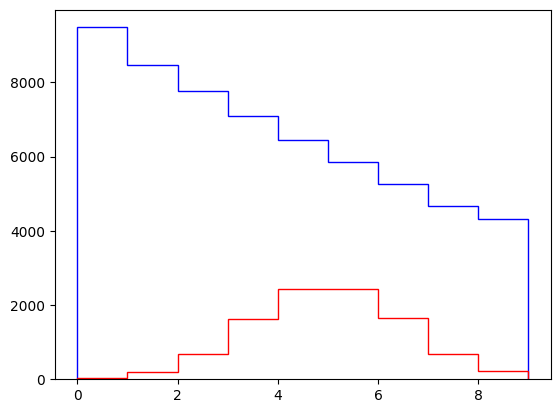

In [5]:
bins = np.arange(0,10)
plt.hist(bkg_samples, bins=bins, histtype='step', color='b')
plt.hist(sig_samples, bins=bins, histtype='step', color='r')


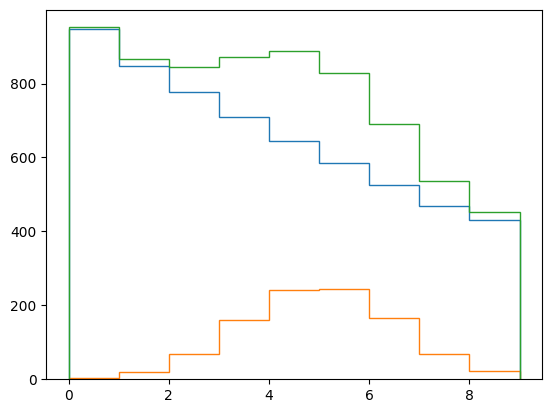

In [6]:
plt.stairs(bkg_hist)
plt.stairs(sig_hist)
plt.stairs(sig_hist+bkg_hist)

# Generate fake data

In [7]:
bkg_samples_data = sp.stats.expon.rvs(loc=0, scale=10., size=100000)
sig_samples_data = sp.stats.norm.rvs( loc=4, scale=1.5, size= 10000)

bkg_hist_data, _ = np.histogram(bkg_samples_data, bins=bins)
sig_hist_data, _ = np.histogram(sig_samples_data, bins=bins)

bkg_hist_data = bkg_hist_data * eff()
sig_hist_data = sig_hist_data * eff()

data = bkg_hist_data + sig_hist_data

In [8]:
data

array([941.1, 943.1, 936. , 948.7, 881. , 753.9, 590.8, 496.1, 444.6])

In [9]:
sig_hist

array([  4. ,  19.4,  68.7, 161.5, 242.6, 244. , 165.5,  67.9,  21.3])

## Null and alternative kinematics

In [10]:
def null_dist(x, m = 5.):
    return 200*sp.stats.norm.pdf(x, loc=m, scale=1.5)

def alt_dist(x, m = 6.):
    return 200*sp.stats.norm.pdf(x, loc=m, scale=1.5)

## Create the joint number densities

In [24]:
joint_nr_dens = np.diag(sig_hist)

joint_nr_dens = modifier.map(sig_samples, [sig_samples], bins, [bins])
joint_nr_dens = joint_nr_dens * eff()

## Set up the custom modifier

In [25]:
new_params = {
                'm'   :{'inits': (5.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
            }

cmod = modifier.Modifier(new_params, alt_dist, null_dist, joint_nr_dens, [bins])

(<Figure size 1400x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

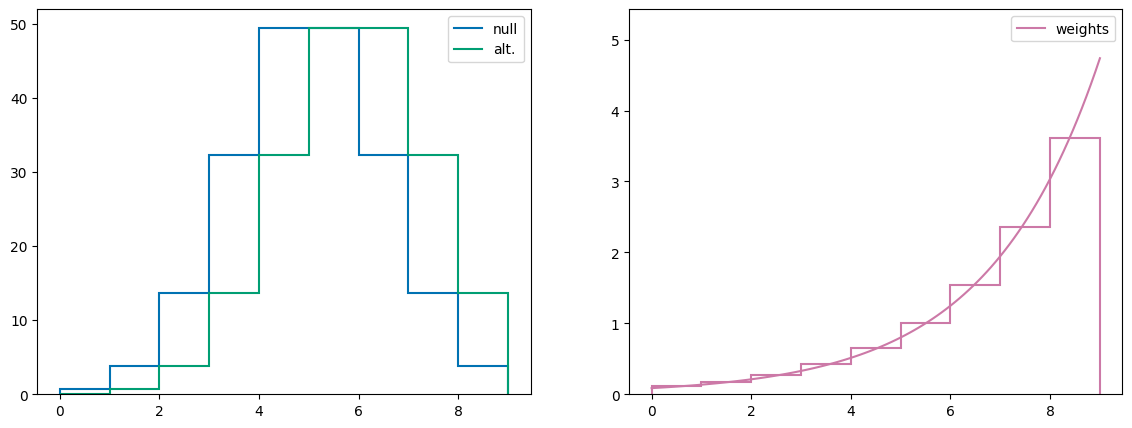

In [26]:
pars = [6.]
plot.dists(cmod, pars, plot_weights=True)

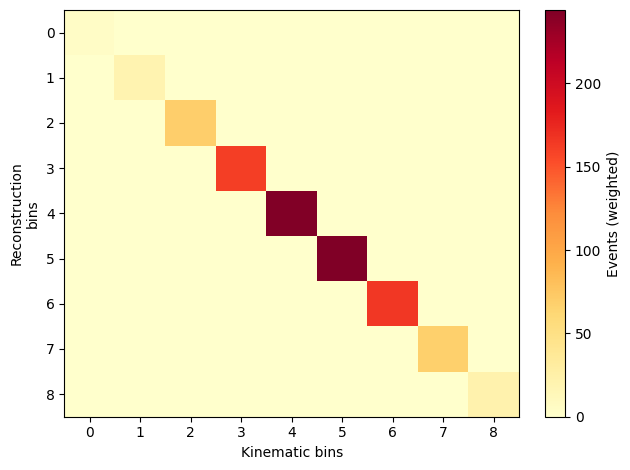

In [27]:
plot.map(cmod, cmap='YlOrRd', aspect='auto');

## Set up the model

In [15]:
samples = [
    dict(name="signal", data=list(sig_hist), modifiers=[dict(name="mu", type="normfactor", data=None)]),
    dict(name="background", data=list(bkg_hist), modifiers=[]),
]
model = pyhf.Model(dict(channels=[dict(name="singlechannel", samples=samples)]))

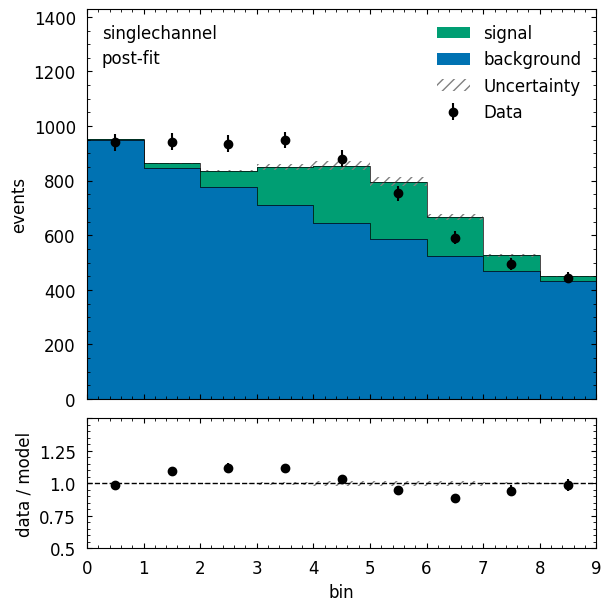

In [16]:
fit_results = cabinetry.fit.fit(model, data.tolist())
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data)

In [17]:
custom_mod = {
                "name": "custom_modifier",
                "type": "custom",
                "data":
                    {
                        "expr": "custom_weight_fn",
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [4.0,
      19.400000000000002,
      68.7,
      161.5,
      242.60000000000002,
      244.0,
      165.5,
      67.9,
      21.3],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'custom_modifier',
       'type': 'custom',
       'data': {'expr': 'custom_weight_fn'}}]},
    {'name': 'background',
     'data': [948.3000000000001,
      846.5,
      776.2,
      710.6,
      645.8000000000001,
      585.3000000000001,
      525.7,
      467.6,
      432.0],
     'modifiers': []}]}]}

In [18]:
model.main_model.modifiers_appliers['custom'].param_viewer.allpar_viewer.names

('m', 'mu')

In [19]:
model.config.par_map

{'m': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7535cec4e590>},
 'mu': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7535cec4e5c0>}}

In [20]:
best_fit = pyhf.infer.mle.fit(data, model)
best_fit

array([4.01310602, 0.99154189])

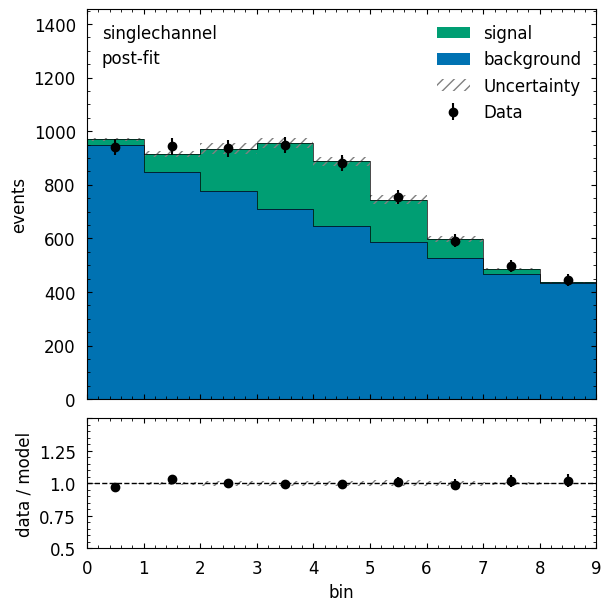

In [21]:
import cabinetry
fit_results= cabinetry.fit.fit(model, data)
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data)

In [22]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

m: 4.014 +/- 0.145
mu: 0.991 +/- 0.070
